# What Lurks Below (Google CTF 2020 Quals; 383pt, 8 solves)
_Written by szabolor from !SpamAndHex_


----

## Immediate Solution with Assumptions and Intuition

The title of this challenge is particularly expressive for a person with DSP background, as they probably immediately associates the "under the noise floor" communication methods based on "What lurks below". The noise floor is the sum of signals which are not observed, so "under the noise floor" means the meaningful (observed) signal is weaker than the interference (unwanted signal), thus the observed signal "hiding" in the noise. By observing the spectrum of such a signal we can't detect it without any a priori knowledge, thus the challenge make sense, as it is not trivial to detect and decode a signal under the noise floor.

To make communication under noise floor possible, the afforementioned a priori information is required to be shared between the sender and the recipient. A very well-known communication shema is DSSS (Direct-Sequence Spread Spectrum), in which the shared knowledge is a _chip sequence_ (and of course the method itself). This sequence has higher bitrate than the data to be transmitted, thus effectively _spreading_ the spectrum. Also a quite common method to implement DSSS is to define 0-bit with the chip sequence and 1-bit with the negated counterpart of the same sequence.

As this is a CTF exercise, the given signal is believed to be fully synthetic (computer generated instead of over-the-air captured), thus many real-world distortions (sampling frequency and baseband frequency offset/jittering, fadings, etc.) are absent. The synthetic signal assumption is also supported by the 1024kHz sampling frequency which isn't used commonly by SDRs. Base on that, let's suppose a single bit from the chip sequence of DSSS takes up integer number of samples and the first chip sequence begins exactly at the first sample of the signal, because that's how one would usually generate a signal. With that assumption so far we know that the whole recording is builds up from a single (still unknown length) chip sequence in its ponated and negated versions, meaning the auto-correlation of the signal should be "peaked", where the peaks are at the multiples of the chip sequence's length. So check the auto-correlation to decide if we are on the right track.


In [4]:
# Import necessary libraries, like numpy and matplotlib
%matplotlib inline
import matplotlib
import numpy as np
import scipy.signal as spsig
import matplotlib.pyplot as plt
from IPython.display import Image

In [5]:
# Setup matplotlib style
plt.style.use("seaborn-whitegrid")
matplotlib.rcParams['axes.titlesize'] = 'x-large'
matplotlib.rcParams['figure.figsize'] = (16, 8)

In [6]:
# Load the samples:
# based on the extension 'cfile' it is belived to be GnuRadio's 64-bit complex number
# (interleaved 32-bit float of in-phase and quadrature components)
samp_rate = 1024e3
rec = np.fromfile("challenge.cfile", dtype=np.complex64)

The assumption is that the first _N_ samples build up the first chip sequence. So correlating the whole signal with the first _N_ samples should result in periodical peak, if we guess _N_ right!

Test values for _N_ can be taken from a wide range: for examle IEEE 802.11b (the old WLAN specification) uses 11-bit width Barker codes, the Gold-codes used by GPS on the other hand 1023-bit in length. Thus initially start from a range of approx. \[10; 3000\].

In [7]:
# correlate with the first N samples
# those N samples is the hypothetical chip sequence
def corr_first_N_corr(N, total=20000):
    # compute correlation
    c = np.absolute(np.correlate(rec[:total], rec[:N], mode='valid'))
    # normalize result for the N-length auto-correlation
    c /= c[0]
    return c

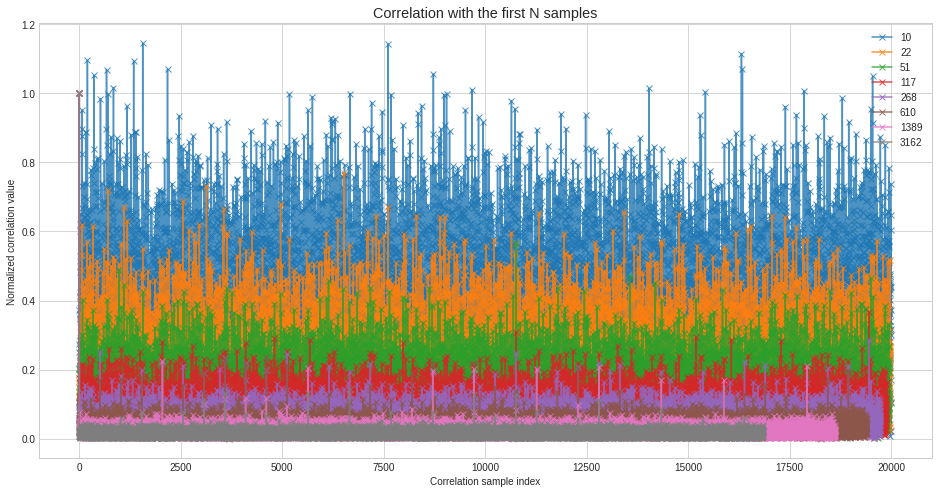

In [8]:
plt.title("Correlation with the first N samples")
plt.xlabel("Correlation sample index")
plt.ylabel("Normalized correlation value")
for l in np.logspace(1, 3.5, 8, dtype=int):
    c = corr_first_N_corr(l)
    plt.plot(c, 'x-', label=f"{l}", alpha=0.8)
plt.legend(loc="upper right");

Up to 268, there are no clear peaks, but in the case of 610 and 1389 there are some visible correlation peaks. This suggests the _N_ we are looking for is somewhere in the \[250; 2500\] range. Let's zoom on that range in the followings. Also try to suppress noise, by a naive, non-linear method: clip everything to zero which doesn't reaches the 3-times mean of the specific correlation.

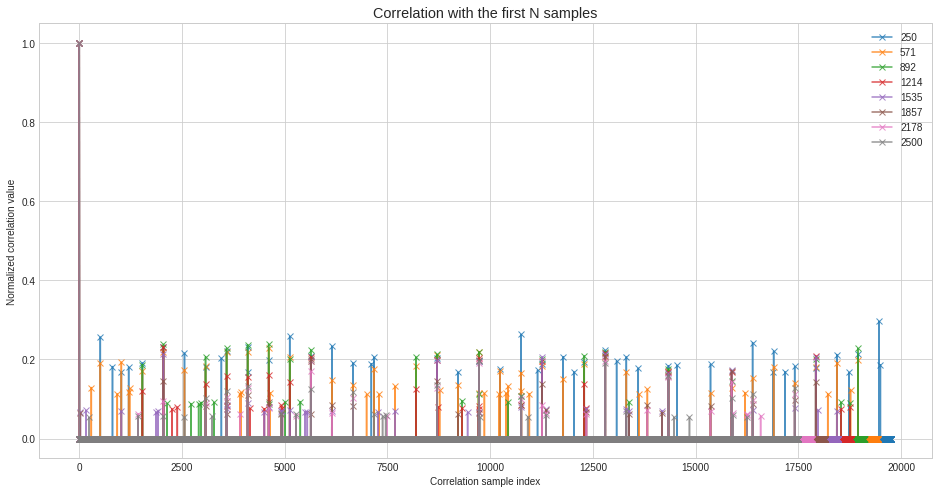

In [9]:
plt.title("Correlation with the first N samples")
plt.xlabel("Correlation sample index")
plt.ylabel("Normalized correlation value")
for l in np.linspace(250, 2500, 8, dtype=int):
    c = corr_first_N_corr(l)
    c[c < 3*c.mean()] = 0
    plt.plot(c, 'x-', label=f"{l}", alpha=0.8)
plt.legend(loc="upper right");

The peaks are definitely visible, now let's make statistics on the location of the peaks to find out the exact value of _N_.

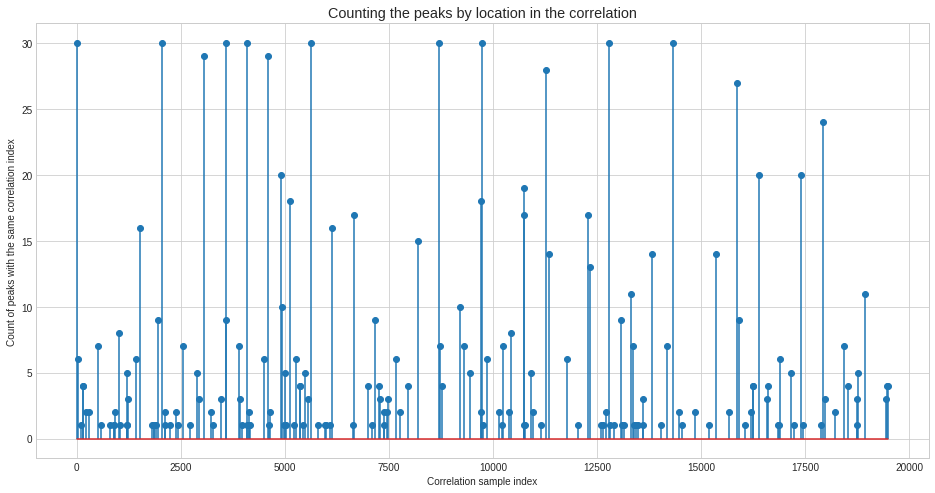

In [10]:
locs = np.array([])
for l in np.linspace(250, 2500, 30, dtype=int):
    c = corr_first_N_corr(l)
    locs = np.append(locs, np.where(c > 3*c.mean())[0])
locs_val, locs_count = np.unique(locs, return_counts=True)
plt.title("Counting the peaks by location in the correlation")
plt.xlabel("Correlation sample index")
plt.ylabel("Count of peaks with the same correlation index")
plt.stem(locs_val, locs_count, 'o');

By counting the locations of the peak for multiple _N_ correlation it is easy to see, that there are values with much higher count than the others. Those higher values should be the _real_ repeation of the chip sequence, so that means if we take the greatest common divisor for those location we should get the chip sequence length (or its multiple). 

In [11]:
# Taking the 14 greatest uniq location (skipping the 0-offset)
N = np.gcd.reduce(np.asarray(locs_val[locs_count.argsort()][-15:-1], dtype=int))
N

512

So probably N=512 (or its divisors)! Now correlate with the first 512 samples (despreading), but this time the correlation offset should be directly 512 (instead of 1, as we did so far), because we know the lenght of a chip sequence.

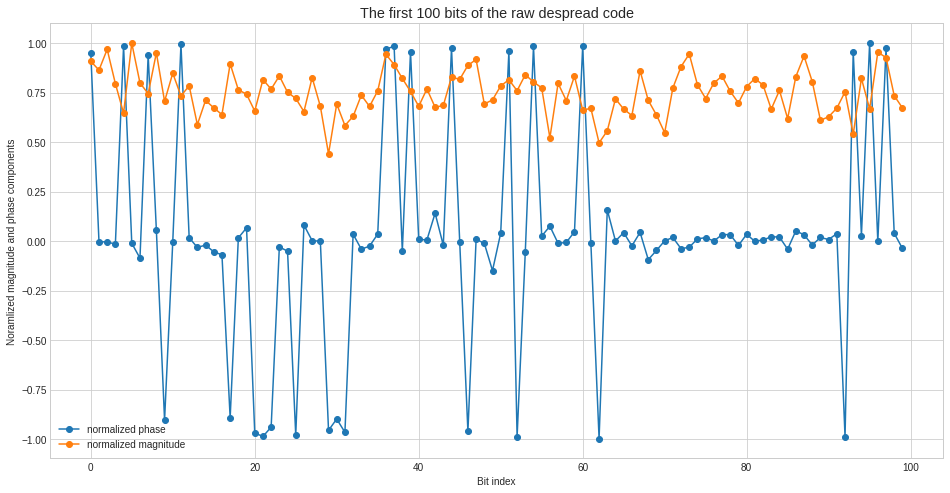

In [12]:
despread = np.array([rec[0:N]@rec[i:i+512] for i in range(0, (len(rec)//N)*N, N)])
plt.title("The first 100 bits of the raw despread code")
plt.xlabel("Bit index")
plt.ylabel("Noramlized magnitude and phase components")
plt.plot(np.angle(despread[:100]) / np.angle(despread[:100]).max(), 'o-', label='normalized phase')
plt.plot(np.absolute(despread[:100]) / np.absolute(despread[:100]).max(), 'o-', label='normalized magnitude')
plt.legend();

After a quick glance of the despreaded signal, we can see that the phase component is the interesting one, which means a BPSK modulation is used. BPSK modulation assign bit 0 to one phase and bit 1 to a 180° shifted phase. Also we can see that in the current plot one bit is assigned to around 0° phase and the other is around 180°, but because the modulo $\pi$ wrapping, the latter bit is sometimes turns over to negative regions (which is completly fine). To demodulate let's assign 0 value to the angles near 0° and 1 to the other -- if this way we can't resemble anything, we'll try reversed!

In [13]:
inner_bits = []
for bit in despread:
    if np.absolute(np.angle(bit)) < (np.pi/2):
        inner_bits.append(0)
    else:
        inner_bits.append(1)

Now assemble the bit string into bytes (conventionally assume first bit is the MSb):

In [14]:
data = int(''.join(map(str, inner_bits)), 2).to_bytes(len(inner_bits)//8, byteorder='big')
data

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x00\x00\x00\x00@\x08\x06\x00\x00\x00\xf5]\xa9\xbe\x00\x00\x02\xb7IDATx\xda\xed\xdd\xdd\xae\xa20\x14\x06P9\xe1\xfd_\xb9seB\x9c\x02\xbb\x7fPt\xad\xbb\xf1 \xd4M\xfb\xd1\x82\x13\x97\x94Rz\x01?\xe9O\t@\x00\x00\x02\x00\x10\x00\x80\x00\x00\x04\x00 \x00\x00\x01\x00\x08\x00@\x00\x00\x02\x00\x10\x00\x80\x00\x00\x04\x00 \x00\x00\x01\x00\x08\x00@\x00\x00\x02\x00\x10\x00\x80\x00\x00\x04\x00 \x00\x00\x01\x00\x0c\xb3\xb6\xbcyY\x96\xff^K)e_/\xd9\xee\xe8\xb7J\xde\xef\xf9\xdc\xa6e_g\xef\xa9\xd9wi\xcd\x8e\xb6\xbb\xeb\xb7[\x96e9\xad\xc5Q\xdbk\xcec\xc9>J\xeb]\xba\xafh?\x1eq\xec\xbd\xfa\xf7\xae\xd5\xdaR\xd4\\\xe7\xd8\xeb4{\x8d+i\xf4YAj:c\xf4\xf8\xbd:\xe2^\x1b\xb7\xafo\xb7\x8dt\xc2\x19\x02\xa1gH\xbd\x8f\xd3\xfa\xd9[\xebX\xd2\x8f{\x1f\xbb\xa6\x9d%\xedk^\x02\xe4\x0e\x94Rz\xcd\xf6Kc3\xb5\'\x1aB3\xd6\xf1\xe8\x9c\x97\xce\xf0j:jm{\xef\xaa\xe3\xac\xe7\xb0y\x06p\xd5\xc9\xeb}2\xaehwdz<\xfa*\xb9\xbd\x1a\xec\xb5%\xf7\xdeY\xcei\xe9\xb4\xb7\xd7\xf9\xad\xa9E\xaf:\x96\xbc\x

The `\x89PNG` is a valid PNG image file header, so it could make sense! Let's try to show it:

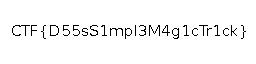

In [15]:
Image(data)

----

## Solution with Signal Exploration

In this solution we won't depend on the title, instead rely solely on the analysis of the recorded signal. For complex-valued signal analysis my go-to tool is [inspectrum](https://github.com/miek/inspectrum); inspectrum can visualize time-frequency (spectrum) graphs of the signal, and also have same handy tools, like showing frequency and phase plots in the selected frequency-range of the signal.

In inspectrum by loading the given file and adjusting the power levels, we can get the following spectrum (x-axis: time, y-axis: frequency):
![initial inspectrum screen](img/inspectrum_init.png)

This shows some noise spreading all over the record bandwidth, but also there is a very narrow band signal around DC starting from 0.1 sec, which seems interesting! Now let's utilize inspectrum's capability of zooming on the signal in both time and frequency domain to further analyse it.
![time domain single chunk](img/inspectrum_time_domain_single_chunk.png)

It seems like the narrow band signal has an about 107 ms durration and it repeated 26 times. Continue the analysis by observing amplitude-, (instantaneous) frequency- and phase-changes in order to determine the modulation type of the signal. The instantaneous frequency (top) and the phase (second from top) plot shows large spikes, indicating something harsh change of the signal. The amplitude plot (bottom) has two disting level, which resembles the 0 and 1 state of a binary data. Also the I/Q (second fom bottom) suggests the binary-like changes happen only in one of the quadratures (I don't know whether it is in-phase or quadrature, as inspectrum doesn't provides legend for the I/Q plot). Based on the two levels we expect an ASK-like modulation on one of the quadratures where 0 and 1 amplitude leves encodes a single bit.
![](img/inspectrum_freq_phase_iq_abs.png)

After we indetified the modulation type, the modulation parameters must be approximated, like a bit-time. For this purposes use inspectrum's cursors.
![bit time](img/inspectrum_bittime.png)

As it can be seen on the bottom plot, the red graph seems to be aligned to a 48.8281 usec-spaced time grid, which is the bit time. This is an amplitude-modulated signal and inspectrum has the ability to create a threashold-plot based on the amplitude plot (quasi making a hard-decision demodulation) and then export the bits aligned to the drawn grid, but a chunk of the narrow band transmission is quite noisy on its own, so let's do the demodulation in python!

Immediately after loading the signal perform a filtering to cut the most of the noise power of the spectrum.

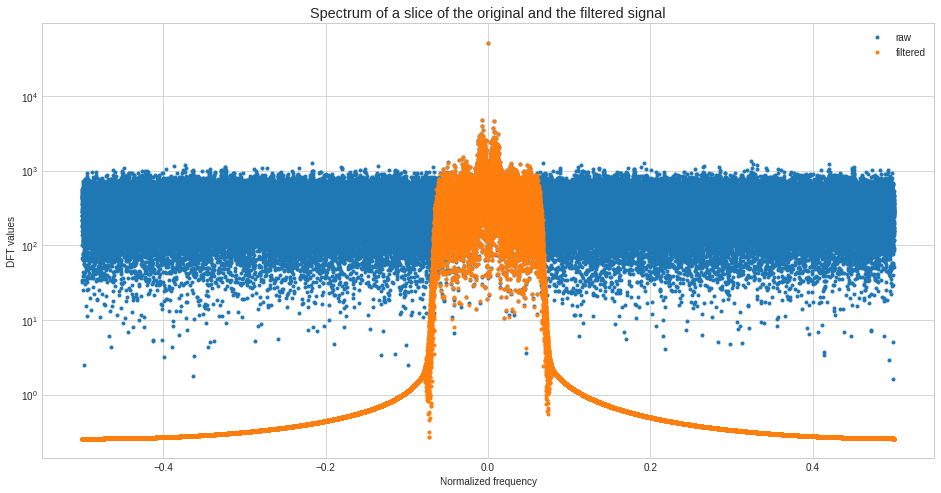

In [16]:
# Load the samples
samp_rate = 1024e3
rec = np.fromfile("challenge.cfile", dtype=np.complex64)

# filter
b, a = spsig.butter(20, 0.13)
rec_filt = spsig.filtfilt(b, a, rec)

# time to sample index
def t2s(t):
    return int(samp_rate*t)

norm_fft_bins = np.arange(-(t2s(1.1)-t2s(1))/2, (t2s(1.1)-t2s(1))/2) / (t2s(1.1)-t2s(1))
plt.title('Spectrum of a slice of the original and the filtered signal')
plt.xlabel('Normalized frequency')
plt.ylabel('DFT values')
plt.semilogy(
    norm_fft_bins,
    np.fft.fftshift(np.absolute(np.fft.fft(rec[t2s(1):t2s(1.1)]))), '.', label='raw')
plt.semilogy(
    norm_fft_bins,
    np.fft.fftshift(np.absolute(np.fft.fft(rec_filt[t2s(1):t2s(1.1)]))), '.', label='filtered')
plt.legend();

In python we can surely tell the data is in the in-phase component:

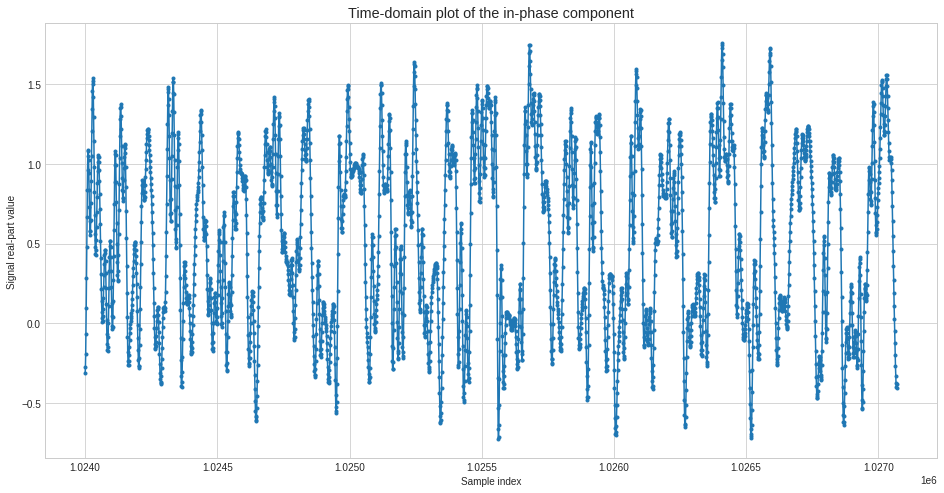

In [17]:
plt.title("Time-domain plot of the in-phase component")
plt.xlabel("Sample index")
plt.ylabel("Signal real-part value")
plt.plot(range(t2s(1), t2s(1.003)), np.real(rec_filt[t2s(1):t2s(1.003)]), '.-');

Let's create some statistics based on the real values of the filtered signal:

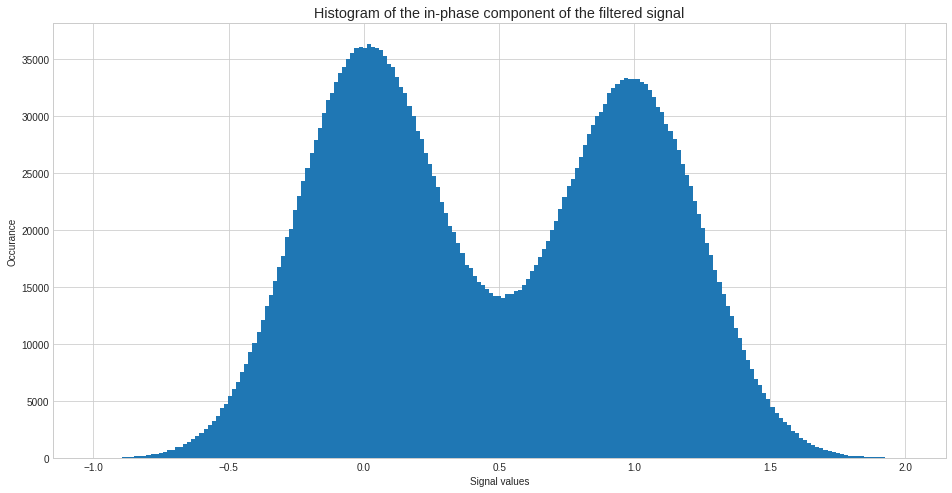

In [18]:
plt.title("Histogram of the in-phase component of the filtered signal")
plt.xlabel("Signal values")
plt.ylabel("Occurance")
plt.hist(np.real(rec_filt), bins=np.linspace(-1,2,200));

The histogram ensures that the two level values are 0 and 1, but also show a considerable amount of noise (look the slope of the 0 and 1 hills). The 26 transmission of the narrow band signal seems to carries the same data, so to overcome the noise, we can combine all of the transmissions. (26 times -> +14 dB SNR is a considerable amount of difference!)

But to be able to coherently accumulate the samples, we must find the exact segment length and the beginning of the first transmission expressed in samples. These can be found by a trial-and-error method by fixing a value pair and then validating on the furthest (26th) segment, looking for beginning offsets.

In [19]:
seg_len = int(np.round(np.average(np.diff([t2s(0.09994), t2s(0.2081), t2s(0.31635), t2s(0.42455), t2s(0.53275)]))))
seg_len += 1 # with manual adjustment
seg_len

110801

In [20]:
offset = t2s(0.09994) - 50; offset # with manual adjustment

102288

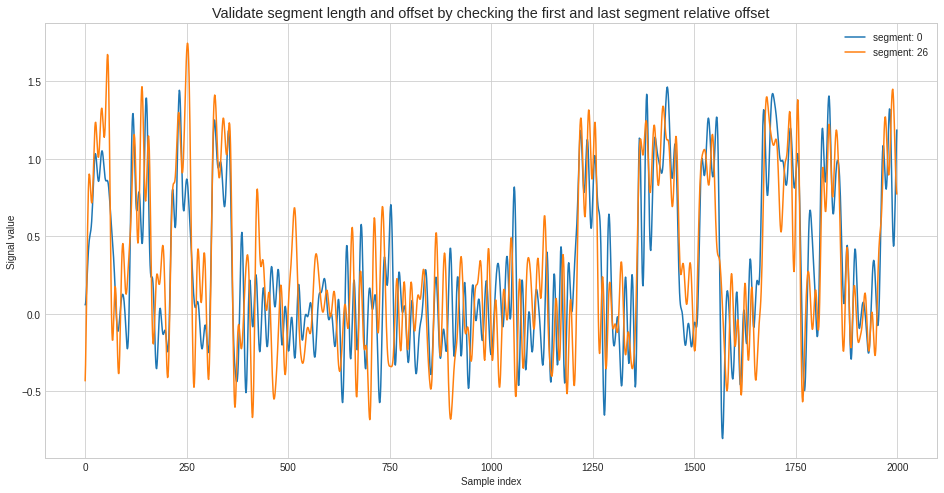

In [21]:
signal = np.real(rec_filt)

plt.title("Validate segment length and offset by checking the first and last segment relative offset")
plt.xlabel("Sample index")
plt.ylabel("Signal value")
seg_idx = 0
plt.plot(signal[offset+seg_len*seg_idx:offset+seg_len*seg_idx+2000], label="segment: 0")
seg_idx = 26
plt.plot(signal[offset+seg_len*seg_idx:offset+seg_len*seg_idx+2000], label="segment: 26")
plt.legend();

When we have the approximately good values, let's accumulate the segments into a single, high SNR (signal-to-noise ratio) power level signal:

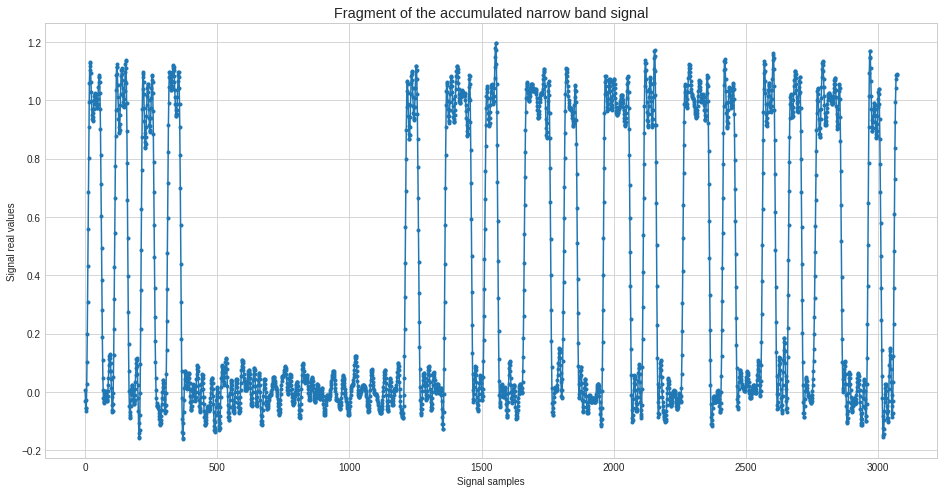

In [22]:
signal_acc = np.sum([signal[offset+seg_len*idx:offset+seg_len*(idx+1)] for idx in range(26)], axis=0)/26
plt.title("Fragment of the accumulated narrow band signal")
plt.xlabel("Signal samples")
plt.ylabel("Signal real values")
plt.plot(signal_acc[t2s(0):t2s(0.003)], '.-');

Repeating the histogram statistics, the slopes of 0 and 1 are steeper, meaning the 0 and 1 separation is more defined.

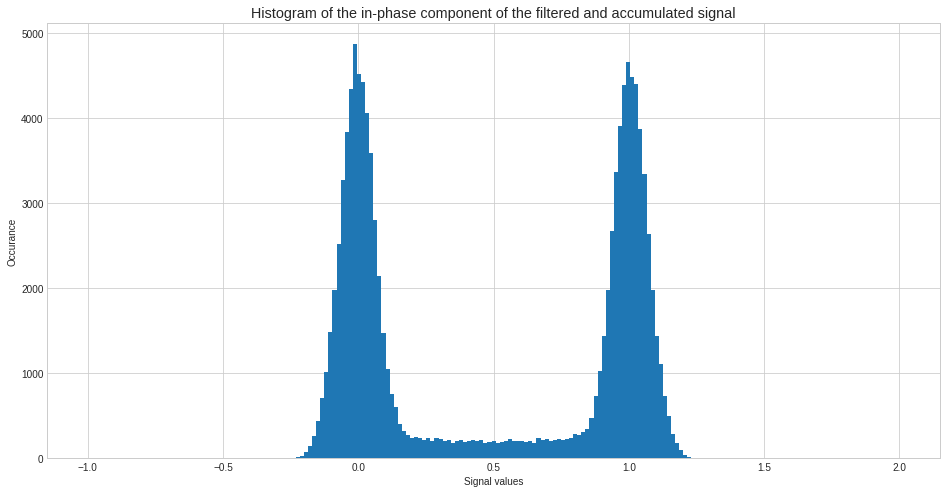

In [23]:
plt.title("Histogram of the in-phase component of the filtered and accumulated signal")
plt.xlabel("Signal values")
plt.ylabel("Occurance")
plt.hist(signal_acc, bins=np.linspace(-1,2,200));

The next task is to demodulate the signal. As the signal is well-oversampled, we don't have calculate the bit-time and sample it in right moment, instead we can simply look for transitions and note the transition time. The differences of the transition times defines the length of a single bit. So repeation of one kind of bit results in longer groups.

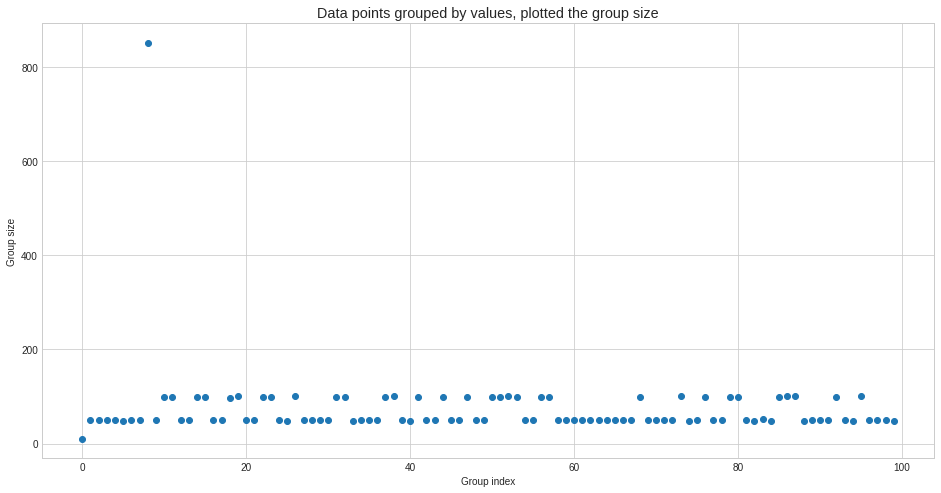

In [24]:
# group the data points by value and count how many are in a group
# a group is consist of a maximal number of consecutive points, where every point is either greater or lower than the pivot variable
def count_runs(a, pivot):
    return np.diff(np.concatenate((np.array([0]), np.where(np.diff(np.array(a) > pivot))[0]+1, np.array([len(a)]))))

plt.title("Data points grouped by values, plotted the group size")
plt.xlabel("Group index")
plt.ylabel("Group size")
plt.plot(count_runs(signal_acc, signal_acc.mean())[:100], 'o');

There is a transient event in the beginning of the narrow band transmission, look at the group value over 800: this could be a pause in the beginning of the transmission. Every other groups are either around 100 or 50 in size. So by this time we can conclude that there is some kind of encoding, because it is unrealistic to have a message where there is no three of the same bit next to each other. A common encoding which resembles this 1 or 2 of a kind pattern is Manchester-encoding, so try to decode with that!

In [25]:
# remove the first transient
diffs = count_runs(signal_acc, signal_acc.mean())[10:-1]

# and try to decode the Manchester coding
bits = [0] # start with 0, if it's wrong replace with 1
diff_idx = 0
while diff_idx < len(diffs):
    if diffs[diff_idx] < 75:
        # short (50) group: same bit
        assert diffs[diff_idx+1] < 75, f"{diff_idx+1}: {diffs[diff_idx+1]}"
        diff_idx += 2
        bits.append(bits[-1])
    else:
        # long (100) group: different bit
        diff_idx += 1
        bits.append(bits[-1] ^ 1)

''.join(map(str, bits))

'010010010010011101110110011001010010000001110011011101000110000101110010011101000110010101100100001000000111010001101000011001010010000001110100011100100110000101101110011100110110011001100101011100100010000000101000011100110110000101101101011100000110110001100101001000000111001001100001011101000110010100100000001111010010000000110001001100000011001000110100011010110010100100101110001000000101010001101000011001010010000001100011011010000110100101110000001000000111001101100101011100010111010101100101011011100110001101100101001000000110100101110011001110100010000000001010100000000000110010110100010000011101010010010011011100001011100000111000011011001011101000001110001101101100000010010100100110101100111011110100001000101101001100001100000101011111000110001001011101101000000100110111110011101101111011100001110111011010101101000010011001111100111000010000000001010100110110000111100011110111100010001100010000010101100001100001111010011001001011110101011010100001101101100110001100100100110

In [26]:
int(''.join(map(str, bits)), 2).to_bytes(len(bits)//8, byteorder='big')

b'I\'ve started the transfer (sample rate = 1024k). The chip sequence is: \n\x80\x0c\xb4A\xd4\x93p\xb88l\xba\x0e6\xc0\x94\x9a\xce\xf4"\xd3\x0c\x15\xf1\x89v\x817\xce\xde\xe1\xdd\xabBg\xce\x10\x05M\x87\x8fx\x8cAXa\xe9\x92\xf5j\x1bf2M\xea\xeb\x7f\xeaV\xf6\xcf\x19\xb6\x16+\n'

That seems to be the message! It mentions the _chip sequence_, which is a sequency used by DSSS communication schema to extend the spectrum of the source data (to combat interference in case of 802.11b or to overcome huge loss in case of GPS). So from this point it should be a straightforward DSSS decoding (despread). Unfortunately we don't know the bit time of the chip sequence, so we can't express it in terms of samples. There's no reference in the narrow band signal to this... Thus at first let's assume 1 sample equals one chip sequence bit.

In [27]:
chip = b'\x80\x0c\xb4A\xd4\x93p\xb88l\xba\x0e6\xc0\x94\x9a\xce\xf4"\xd3\x0c\x15\xf1\x89v\x817\xce\xde\xe1\xdd\xabBg\xce\x10\x05M\x87\x8fx\x8cAXa\xe9\x92\xf5j\x1bf2M\xea\xeb\x7f\xeaV\xf6\xcf\x19\xb6\x16+'
len(chip)

64

In [28]:
seq = np.array([1 if i == '1' else -1 for i in bin(int.from_bytes(chip, byteorder="big"))[2:].zfill(64*8)])
seq = np.repeat(seq, 1) # 1 chip sequence bit equals 1 sample
len(seq)

512

Do the despread! After that plot the correlation to search for peaks (as peaks ensure the correct chip sequence). Also weight the peaks (absolute value of the correlation) with its angle to make a visual cue for BPSK modulation (as 180° phase change mostly results in negation).

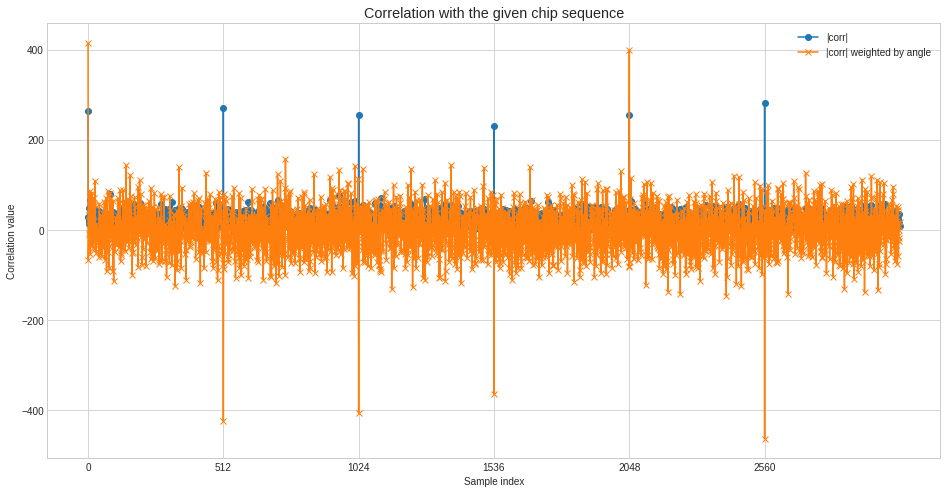

In [29]:
mult = np.correlate(rec, seq, 'valid')

tmp = mult[:t2s(0.003)]
plt.title("Correlation with the given chip sequence")
plt.xlabel("Sample index")
plt.ylabel("Correlation value")
plt.xticks(range(0, len(tmp), len(seq)))
plt.plot(np.absolute(tmp), 'o-', label='|corr|')
plt.plot(np.angle(tmp)*np.absolute(tmp), 'x-', label='|corr| weighted by angle')
plt.legend();

As we are still not 100% sure that the chip sequence bits are sample-aligned (but they are indeed) and shares the same beginning as the recorded signal itself, let's find the peaks with a quite permissive range of 200:

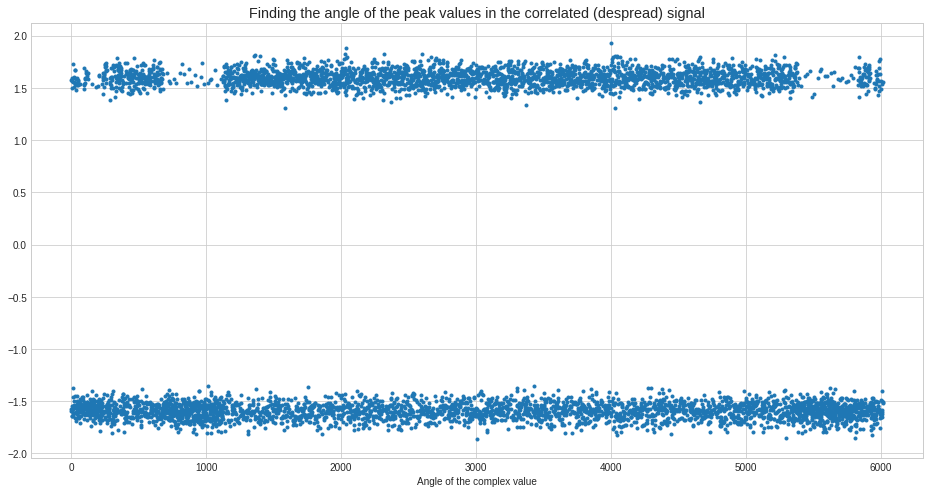

In [30]:
peaks = []
for i in range(0, len(mult), len(seq)):
    peak = max(mult[range(max(i-100, 0), min(i+100, len(mult)))], key=np.absolute)
    peaks.append(peak)

plt.title("Finding the angle of the peak values in the correlated (despread) signal")
plt.xlabel("Peak indexes (bit indexes)")
plt.xlabel("Angle of the complex value")
plt.plot(np.angle(peaks), '.');

In the previous plot it is obvious that there are two distinct angles, so the modulation is indeed BPSK. Our final task is to decode the angles into bits and make sense the data:

In [31]:
inner_bits = []
for p in peaks:
    if np.angle(p) > 0: # zero is a good pivot point
        inner_bits.append(1)
    else:
        inner_bits.append(0)

''.join(map(str, inner_bits))

'100010010101000001001110010001110000110100001010000110100000101000000000000000000000000000001101010010010100100001000100010100100000000000000000000000010000000000000000000000000000000001000000000010000000011000000000000000000000000011110101010111011010100110111110000000000000000000000010101101110100100101000100010000010101010001111000110110101110110111011101110111011010111010100010001100000001010000000110010100000011100111100001111111010101111110111001011100110110010101000010100111000000001010111011011111110101000001110100101011011011101111110001001000001101010001001101111110111101000110000010000100111001011110010100010100100111101000000001001111111110100101001111000010010100000000000000000000000000001000000000000100000000000010000000000000000000000000000100000000000010000000000000000000000000000100000000000010000000000001000000000000000000000000000010000000000001000000000000100000000000000000000000000001000000000000100000000000000000000000000001000000000000100000000000010000000000000

In [32]:
data = int(''.join(map(str, inner_bits)), 2).to_bytes(len(inner_bits)//8, byteorder='big')
data

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x00\x00\x00\x00@\x08\x06\x00\x00\x00\xf5]\xa9\xbe\x00\x00\x02\xb7IDATx\xda\xed\xdd\xdd\xae\xa20\x14\x06P9\xe1\xfd_\xb9seB\x9c\x02\xbb\x7fPt\xad\xbb\xf1 \xd4M\xfb\xd1\x82\x13\x97\x94Rz\x01?\xe9O\t@\x00\x00\x02\x00\x10\x00\x80\x00\x00\x04\x00 \x00\x00\x01\x00\x08\x00@\x00\x00\x02\x00\x10\x00\x80\x00\x00\x04\x00 \x00\x00\x01\x00\x08\x00@\x00\x00\x02\x00\x10\x00\x80\x00\x00\x04\x00 \x00\x00\x01\x00\x0c\xb3\xb6\xbcyY\x96\xff^K)e_/\xd9\xee\xe8\xb7J\xde\xef\xf9\xdc\xa6e_g\xef\xa9\xd9wi\xcd\x8e\xb6\xbb\xeb\xb7[\x96e9\xad\xc5Q\xdbk\xcec\xc9>J\xeb]\xba\xafh?\x1eq\xec\xbd\xfa\xf7\xae\xd5\xdaR\xd4\\\xe7\xd8\xeb4{\x8d+i\xf4YAj:c\xf4\xf8\xbd:\xe2^\x1b\xb7\xafo\xb7\x8dt\xc2\x19\x02\xa1gH\xbd\x8f\xd3\xfa\xd9[\xebX\xd2\x8f{\x1f\xbb\xa6\x9d%\xedk^\x02\xe4\x0e\x94Rz\xcd\xf6Kc3\xb5\'\x1aB3\xd6\xf1\xe8\x9c\x97\xce\xf0j:jm{\xef\xaa\xe3\xac\xe7\xb0y\x06p\xd5\xc9\xeb}2\xaehwdz<\xfa*\xb9\xbd\x1a\xec\xb5%\xf7\xdeY\xcei\xe9\xb4\xb7\xd7\xf9\xad\xa9E\xaf:\x96\xbc\x

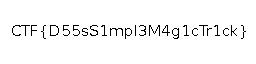

In [33]:
Image(data)